In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split

In [2]:
images_csv = pd.read_csv('data.csv')

In [3]:
images_csv = images_csv[['path', 'label']]
images_csv.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [4]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'Surprise': 0, 'Sad': 1, 'Ahegao': 2, 'Happy': 3, 'Neutral': 4, 'Angry': 5}


In [5]:
e_images = images_csv.replace(emotions_dic)

In [6]:
Sizes = []
for i in e_images['path']:
    image = cv.imread(f'dataset/{i}')
    height = image.shape[0]
    width = image.shape[1]
    Sizes.append(height*width)

In [7]:
min(Sizes), max(Sizes)

(96, 19483396)

In [8]:
e_images.insert(2, 'Sizes', Sizes)

In [9]:
e_images['Sizes'].describe()

count    1.545300e+04
mean     3.031597e+05
std      7.051823e+05
min      9.600000e+01
25%      4.840000e+04
50%      1.004890e+05
75%      2.672890e+05
max      1.948340e+07
Name: Sizes, dtype: float64

In [10]:
mean_size = e_images['Sizes'].describe().loc['mean']
mean_size

303159.73946806445

In [11]:
diffrence = 100000
photo_filter = (e_images['Sizes'] >= diffrence)
e_images_filtered = e_images.loc[photo_filter]
e_images_filtered

,path,label,Sizes
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,0,230400
4,Surprise/cropped_emotions.263616~12fffff.png,0,187833
7,Surprise/0a15c44d8be6cc71cd9d8ab595266e5147459...,0,459684
9,Surprise/cropped_emotions.263517~12fffff.png,0,166160
10,Surprise/cropped_emotions.265653~12fffff.png,0,128310
...,...,...,...
15439,Angry/cropped_emotions.571531~angry.png,5,412125
15440,Angry/cropped_emotions.157999~angry.png,5,106110
15441,Angry/cropped_emotions.231380~angry.png,5,194530
15442,Angry/cropped_emotions.232172~angry.png,5,350620


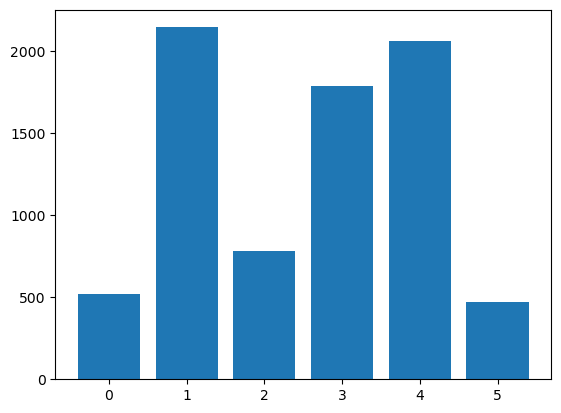

In [12]:
photos_by_emotions = e_images_filtered.groupby('label').count()
plt.bar(photos_by_emotions.index, photos_by_emotions['path']);

In [13]:
X = e_images_filtered['path']
y = e_images_filtered['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [15]:
Images = []
for i in X_train:
    image = cv.imread(f'dataset/{i}')
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    resize_image = cv.resize(rgb_image, (100, 100))
    std_image = resize_image / 255
    Images.append(std_image)

In [24]:
y_train_n = y_train.to_numpy()

In [35]:
Images[4].dtype

dtype('float64')

In [43]:
np.array(Images).shape

(6204, 100, 100, 3)

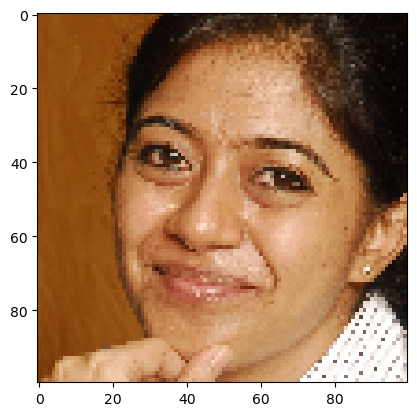

In [22]:
plt.imshow(Images[4]);

In [25]:
y_train_n[4]

3

In [31]:
y_dummies = pd.get_dummies(y_train)

In [38]:
y_dummies.to_numpy().astype(float).shape

(6204, 6)

In [14]:
class CTDataset(Dataset):
    def __init__(self, X, y):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        X_images = []
        for i in X:
            image = cv.imread(f'dataset/{i}')
            rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            resize_image = cv.resize(rgb_image, (100, 100))
            std_image = resize_image / 255
            X_images.append(std_image)

        X_images_np = np.array(X_images)
        X_images_np = np.moveaxis(X_images_np, 3, 1)

        self.x = torch.from_numpy(X_images_np).to(device)
        y_one_hot = pd.get_dummies(y)
        self.y = torch.from_numpy(y_one_hot.to_numpy().astype(float)).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]     

In [52]:
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # First layer
        self.conv1 = nn.Conv2d(3, 10, (10, 10)).to(device)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        # Second layer
        self.conv2 = nn.Conv2d(10, 20, (10, 10)).to(device)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        # Third layer
        self.conv3 = nn.Conv2d(10, 20, (10, 10)).to(device)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 2)
        # To linear
        self.flatten = nn.Flatten()
        # self.linear = nn.Linear().to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)

        return x

In [15]:
train_data = CTDataset(X_train, y_train)

In [16]:
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True)

In [17]:
# f = CNN_model()
for i in train_data_loader:
    print(i[0].shape)
    break

IndexError: index 5128 is out of bounds for dimension 0 with size 100